# Lab 5: Introduction to Convolutional Neural Networks (Solutions)

This lab has the following goals:
- Introduce convolutions in Numpy and Pytorch.
- Introduce image filters and detectors.
- Learn how to load pretained models from Pytorch and understand their structure such as AlexNet

**Note:** There will be no training in this lab!


# Exercise 1: Numpy Edge Detection
To build intuition about convolutions we begin by implementing an image edge detection filter in numpy.

Run the cells below

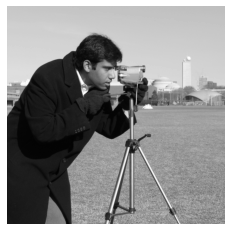

In [ ]:
from skimage import data
import matplotlib.pyplot as plt

camera = data.camera()
plt.figure(figsize=(4, 4))
plt.imshow(camera, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
import numpy as np

kernel = np.array([[-1,-1,-1],
                   [-1,8,-1],
                   [-1,-1,-1]])
kernel = kernel/8.0

## 1.1 Numpy 2D Convolution
Write a double for loop to convolve the edge detection kernel from the above code cell with the camera image.

- Apply the filter with `stride=2` and `pad=0`.
- Your output's width should be $\frac{image~width - filter~width} {stride} +1 $. Similarly, you can find the length of the output. You can find the complete formula in the [slides posted on moodle](https://moodle.concordia.ca/moodle/pluginfile.php/5884784/mod_resource/content/1/Lecture%205.pdf).
- Plot the absolute value of the edge detection output using matplotlib's `imshow`.

You can refer to this [example of 2D convolution](https://www.songho.ca/dsp/convolution/convolution2d_example.html) when implementing your code.

Your final output should look like the image below.

<center>
<!-- <img src="https://drive.google.com/uc?id=11fFJ3QrbF87w8ChZF45p-5uXtmxZU8Qv"> camera image from old library version! -->
<img src="https://drive.google.com/uc?id=1bgjdeF1Ls20586nzsG2mqqo7RTtTkXR4">


(255, 255)


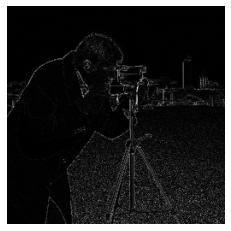

In [ ]:
H, W = camera.shape
stride = 2
ker_sz = kernel.shape[0]

# compute convolution output size
from math import floor
pad = 0  # no padding
out_H = floor((H - ker_sz + 2*pad) / stride + 1)
out_W = floor((W - ker_sz + 2*pad) / stride + 1)
output = np.zeros((out_H, out_W))
print(output.shape)

# initialize iterators for output image
h = 0
w = 0

# perform convolution
for i in range(0, H, stride):
  w = 0
  for j in range(0, W, stride):
    if (i + ker_sz < H and j + ker_sz < W):  # index shouldn't exceed image size
      patch = camera[i:i+ker_sz, j:j+ker_sz]
      output[h, w] = (patch * kernel).sum()
    w += 1
  h += 1

# visualize
plt.figure(figsize=(4, 4))
plt.imshow(np.abs(output), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
output.shape

(255, 255)

# Exercise 2: PyTorch Convolution

Now let's take a look at `torch.nn.conv2d`.

Run the cell below to convolve 5 random kernels on the camera man image and see the shapes of the parameters.


**Note:** An image tensor has the following dimensions $(N,C,H,W)$, where $N$ is the batch size/number of images and $C$ is the number of color channels. In this exercise you only have 1 image!



In [ ]:
import torch

conv_nn = torch.nn.Conv2d(1, 5, kernel_size=3,stride=2)
conv_nn.bias.data.zero_()
img_in = torch.FloatTensor(camera)[None,None,:,:]

filtered_camera = conv_nn(img_in)
print(filtered_camera.shape)
print(conv_nn.weight.data.shape)

# To compute the output keep in mind these variables and the formula for H,W output in torch.nn.Conv2d
print(conv_nn.dilation)
print(conv_nn.stride)
print(conv_nn.padding)
print(conv_nn.kernel_size)


torch.Size([1, 5, 255, 255])
torch.Size([5, 1, 3, 3])
(1, 1)
(2, 2)
(0, 0)
(3, 3)


## 2.1 Functional 2D Convolution

Consider a minibatch of a randomly generated images (`toy_train_images`). Pass these images through the randomly initialized convolutional layer above.

Take the weights from the convolution layer above and implement the convolution. You can use nested for loops.

**Note**: By default, PyTorch uses channels first representation of images $(N, C, H, W)$ as opposed to $(N, H, W, C)$, where $N=$ number of samples, $H=$ image height, $W=$ image width, and $C=$ number of image channels, e.g. 3 for rgb).




In [ ]:
mini_batch = 10
height=width = 12
input_features = 1
num_features = 5
toy_train_images = torch.rand(mini_batch, input_features, height, width) #this is usually the structure we input image data

import torch.nn as nn
import copy

my_weight=copy.deepcopy(conv_nn.weight.data)



def my_conv_nn(x):
    # Implement a for loop based convolution here. Don't worry about making sure autograd tracks this.
    H = height
    W = width
    ker_sz = 3
    stride = 2

    weight = my_weight
    weight = weight.view(1 , num_features, 1, ker_sz*ker_sz)

    output = torch.zeros((mini_batch,num_features,int((height-2)/stride),int((width-2)/stride)))
    for h in np.arange(1, H-2, stride):
      for w in np.arange(1, W-2, stride):
        a = x[:,:,h-(ker_sz-stride):h+(ker_sz-stride)+1,w-(ker_sz-stride):w+(ker_sz-stride)+1]
        a = a.contiguous()
        b = weight
        a = a.view(mini_batch, input_features, ker_sz*ker_sz, 1 )
        val = torch.matmul(b,a).squeeze()
        output[:,:,int(h/stride),int(w/stride)] = val

    print(output.shape)
    return output

assert(torch.norm(my_conv_nn(toy_train_images)-conv_nn(toy_train_images))<1e-3)

torch.Size([10, 5, 5, 5])


Confirm your custom function has the same behavior as `torch.nn.Conv2d` on the camera image.

In [ ]:
my_out = my_conv_nn(toy_train_images, my_weights) # outputs the convolution using the function above
torch_out = conv_nn(toy_train_images) # outputs the convolution using the nn.Conv2d layer
assert my_weights.shape == (5, 1, 3, 3), f"Incorrect shape for 'my_weights' ({my_weights.shape})."
assert torch.is_tensor(my_out), "Your function output is not a torch.Tensor"
assert my_out.shape == torch_out.shape, f"Incorrect output shape ({my_out.shape})."
assert torch.norm(my_out - torch_out) < 1e-3, "Incorrect function output values compared to torch module"
print('Well done! Your function has the same behaviour as torch.nn.Conv2d')

## 2.2 Modular 2D Convolution

Build a small convnet using `torch.nn.Module` with two layers and forward pass the astronaut image from `skimage` through it.

**Note:** You do not need to train the model for this exercise. You should only use the `torch.nn.Conv2d` for this part.

The convnet should have the following specifications:<br>

* Activation Function: `ReLU` <br>
* Layer1: filter size `(5,5)`, out_channels `16`, stride `2` convolution layer <br>
* Layer2: `(2,2)` pooling layer <br>
* Layer3: filter size `(3,3)`, out_channels `32`, stride `2` convolution layer <br>
* Layer4: linear layer with `5` output units. Note that for the number of input neurons to the linear layer, you need to keep track of the shape of the image as it passes through the CNN using the formula in [the lecture slides](https://https://moodle.concordia.ca/moodle/pluginfile.php/5884784/mod_resource/content/1/Lecture%205.pdf).


In your forward function add print statements to show the size of the image at each layer.


astronaut.shape: (512, 512, 3)


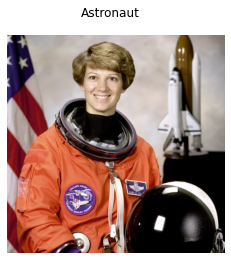

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import data

# load and the astronaut image
astronaut_np = data.astronaut()
print(f"astronaut.shape: {astronaut_np.shape}")

# visualize the original and preprocessed astronaut image
# fig, ax = plt.subplots(1, 1)
fig = plt.figure()
fig.suptitle("Astronaut")
plt.imshow(astronaut_np)
plt.axis('off')
fig.show()

Run below cell to convert the astronaut image into a tensor and reshape it into the shape that PyTorch expects.

In [ ]:
# convert the astronaut image to torch.tensor
astronaut = torch.tensor(astronaut_np, dtype=torch.float32)

# torch convolutions expect channels first representation
# of shape (N, C, H, W)
astronaut = astronaut.permute(2, 0, 1).unsqueeze(0)
print(f'astronaut.shape: {astronaut.shape}')

In [ ]:
import torch
import torch.nn.functional as F
from skimage import data

class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        ### TODO: Define layers based on description above
        self.conv1 = None
        self.pool = None
        self.conv2 = None
        self.linear = None


    def forward(self, x):
        ### TODO: Compelete forward pass, print image size after each layer
        pass

astronaut = data.astronaut()
print(f"astronaut.shape: {astronaut.shape}")

model = MyModel()
model(astronaut_processed)

# Exercise 3: Pretrained AlexNet Model


In this section, we will visualize a subset of the first layer filters of the pretrained AlexNet and the result of applying these filters to the astronaut image.

Run the below cell to download the trained [AlexNet](https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) model using [PyTorch Hub](https://pytorch.org/docs/stable/hub.html)'s [`torch.hub.load()`](https://pytorch.org/docs/stable/hub.html#torch.hub.load) method. The model is switched to `eval()` mode since we will not be doing any training in this lab:

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## 3.1 Input data to the AlexNet

Since we are using a pretrained model, we need to make sure that our data has a similar distribution to the training data that the model was trained on. For our case here, this means that we need to preprocess the data in a similar manner to how it was done in the [original training pipeline](https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198).

Run the below cell to preprocess and visualize the astronaut image.

In [ ]:
# No need to modify this cell it preprocesses the astronaut data for alexnet
import numpy as np
from skimage import data
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
print(data.astronaut().shape)
astronaut_processed = data.astronaut()/255.0
astronaut_processed = (astronaut_processed-mean[None,None,:])/std[None,None,:]


(512, 512, 3)


## 3.2 Visualizing AlexNet Kernels

The kernels (filters) in the first layer of AlexNet are of size 11. Visualize a randomly selected subset of 20 of these first layer filters as well as the respective output of convolving each kernel with the astronaut image. You can use either pytorch `F.conv2d` or your custom convolution implementation.

Remember that the shape of the input is (# of images, # of color channels, H,W), the shape of a kernel is (# of out channels, # of in channels, H,W), and the shape of the output image is (# of images, # of color channels, H,W)

Your answer will look something like this
<center>
<img src="https://drive.google.com/uc?id=1azdohWuo3EEO9KC0szZmJOywX54jXlPz">

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
torch.Size([1, 64, 127, 127])
torch.Size([127, 127])


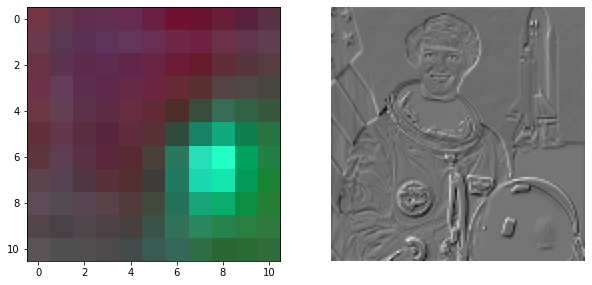

torch.Size([127, 127])


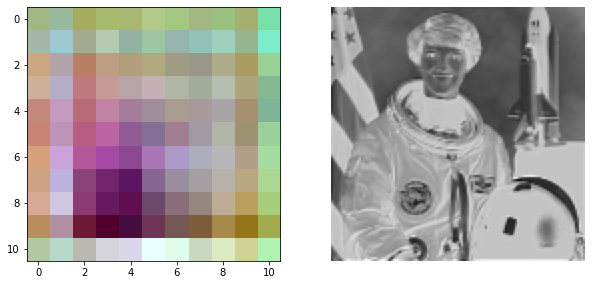

torch.Size([127, 127])


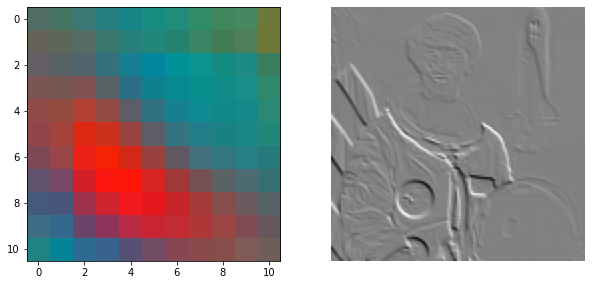

torch.Size([127, 127])


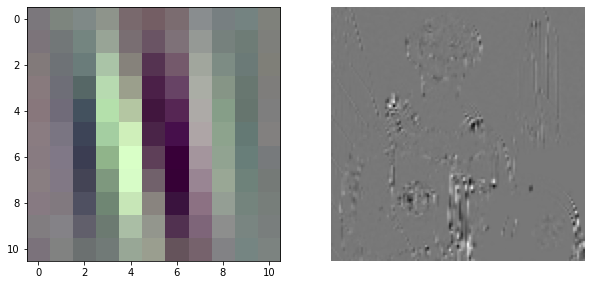

torch.Size([127, 127])


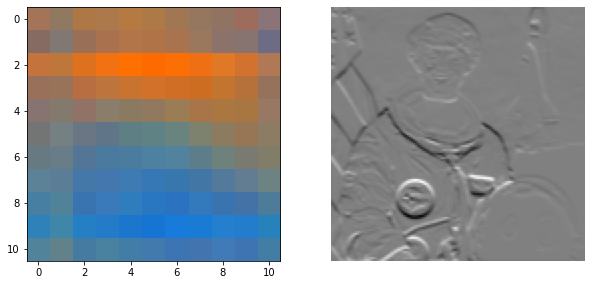

torch.Size([127, 127])


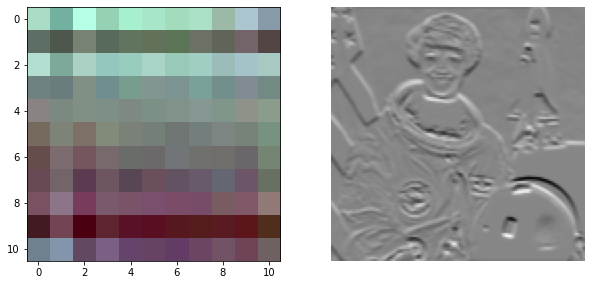

torch.Size([127, 127])


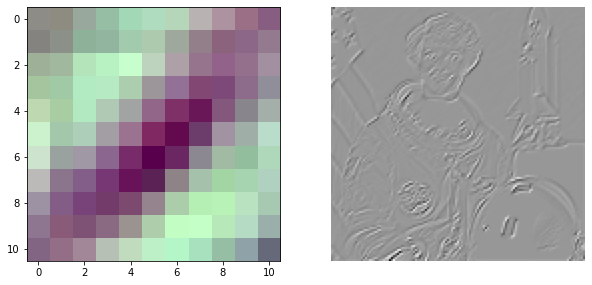

torch.Size([127, 127])


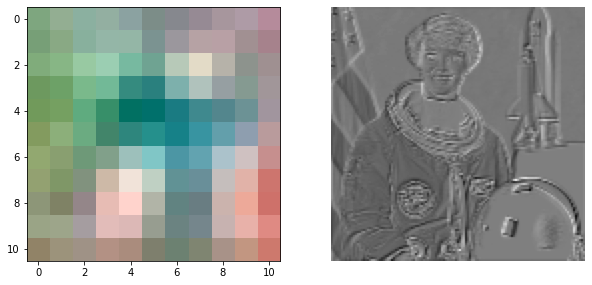

torch.Size([127, 127])


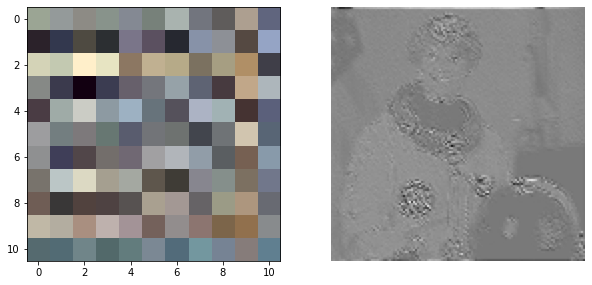

torch.Size([127, 127])


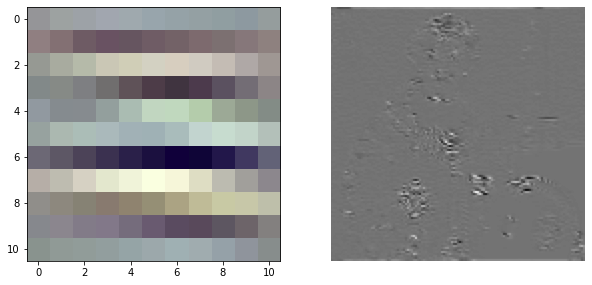

In [ ]:
import matplotlib.pyplot as plt

first_layer = model.features[0]
first_layer_weights = first_layer.weight

image = torch.FloatTensor(astronaut_processed).permute(2,1,0).unsqueeze(0)

# Write your answer here
print(first_layer)
image_features = first_layer(image)
print(image_features.shape)
ind = np.arange(0,10)

# print(filter.data.cpu().numpy().shape)
for i in ind:
  filter = first_layer_weights[i]
  filter = filter.permute(2,1,0).data.cpu().numpy()
  imag_out = image_features[0][i].T
  print(imag_out.shape)
  plt.figure(figsize=(10, 10))
  plt.subplot(1,2,1)

  plt.imshow((filter - filter.min()) / filter.ptp(),cmap='gray')
  plt.subplot(1,2,2)
  plt.imshow(imag_out.data.cpu().numpy(),cmap='gray')
  plt.axis('off')
  plt.show()

Build a small convnet using nn.modules with two layers and forward pass the astronaut image through it. You do not need to train it for this excercise.

The convnet should have the following specifications. It should use relu non-linearities and initializations will be the default. Use the nn.Conv2d modules for this

layer 1 - 5x5 filters with 16 feature maps stride 2 with 10 feature maps

layer 2 - 2x2 pooling

layer 3 - 3x3 filters with 32 feautre maps

layer 4 - final linear projection

In your forward function add some print statemetns to show the sizes of the image at each layer.


In [ ]:
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels= 3 , out_channels=16, kernel_size= 5, stride=2)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels= 16 , out_channels=32, kernel_size= 3, stride=2)
        self.linear = torch.nn.Linear(63*63*32,5)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        print(x.shape)

        x = self.pool(x)
        print(x.shape)

        x = F.relu(self.conv2(x))
        print(x.shape)
        x = self.linear(x.view(-1,63*63*32))
        print(x.shape)

        return x

model = MyModel()
in_image = torch.FloatTensor(astronaut_processed).permute(2,0,1)
in_image = in_image.unsqueeze(0) #BxFxHxW
model(in_image)

torch.Size([1, 16, 254, 254])
torch.Size([1, 16, 127, 127])
torch.Size([1, 32, 63, 63])
torch.Size([1, 5])


tensor([[ 0.2487,  0.1688,  0.0109,  0.0158, -0.2722]],
       grad_fn=<AddmmBackward0>)